## Generating Tables/Figures for Stratification Results

In [1]:
# Load necessary packages 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patheffects as pe

### Prepping Data 

In [2]:
# Pull all the stratified results from folder 
# Separate each covariate group (Unadjusted, Group1, Group2, Group3) into its own df.

folder_path = "stratified_results"

unadjusted = []
group1_dfs = [] 
group2_dfs = [] 
group3_dfs = [] 

# Loop through each Excel file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".xlsx"):
        file_path = os.path.join(folder_path, filename)

        # Load all sheets as a dictionary of DataFrames
        all_sheets = pd.read_excel(file_path, sheet_name=None)

        # Loop through each sheet in the Excel file and assign to respective df 
        for sheet_name, df in all_sheets.items():
            df = df.copy()
            df["Source_File"] = filename 

            if sheet_name == "Unadjusted":
                unadjusted.append(df)
            elif sheet_name == "Group1":
                group1_dfs.append(df)
            elif sheet_name == "Group2":
                group2_dfs.append(df)
            elif sheet_name == "Group3":
                group3_dfs.append(df)

In [3]:
# Concatenate all dataframes in each group list
unadjusted_all = pd.concat(unadjusted, ignore_index=True)
group1_all = pd.concat(group1_dfs, ignore_index=True)
group2_all = pd.concat(group2_dfs, ignore_index=True)
group3_all = pd.concat(group3_dfs, ignore_index=True)

In [4]:
# Create exposure/mediator pair variables and rename for clarity 
unadjusted_all["Pair"] = unadjusted_all["Exposure"] + " + " + unadjusted_all["Mediator"]
group1_all["Pair"] = group1_all["Exposure"] + " + " + group1_all["Mediator"]
group2_all["Pair"] = group2_all["Exposure"] + " + " + group2_all["Mediator"]
group3_all["Pair"] = group3_all["Exposure"] + " + " + group3_all["Mediator"]

pair_mapping = {
    "avg_spo2_no_desat_NREM + SP_DENS_all_C": "Basal SpO₂ + Spindle Density",
    "avg_spo2_no_desat_NREM + SP_CHIRP_all_C": "Basal SpO₂ + Spindle Chirp",
    "avg_spo2_no_desat_NREM + SP_R_PHASE_IF_all_C": "Basal SpO₂ + Spindle-SO Coupling Phase",
    "hb_desat + SP_DENS_all_C": "Hypoxic Burden (T) + Spindle Density",
    "hb_desat + SP_CHIRP_all_C": "Hypoxic Burden (T) + Spindle Chirp",
    "hb_desat + SP_R_PHASE_IF_all_C": "Hypoxic Burden (T) + Spindle-SO Coupling Phase"
}

for df in [unadjusted_all, group1_all, group2_all, group3_all]:
    df["Pair"] = df["Pair"].map(pair_mapping) 


In [5]:
# Add a 'Stratification' column based on the source filename
# Extracts stratification label from filename and maps it to a readable label

for df in [unadjusted_all, group1_all, group2_all, group3_all]:
    df["Stratification"] = df["Source_File"].str.extract(r"medRESULTS_(.+)\.xlsx")

    strat_map = {
        "female": "Females",
        "male": "Males",
        "below65": "< 65",
        "above65": "≥ 65",
        "belowcollege":"College-",
        "abovecollege": "College+",
        "obesebmi":"BMI-Obese",
        "overweightbmi":"BMI-Overweight",
        "males_above65": "Males ≥ 65",
        "females_above65":"Females ≥ 65"
    }
    df["Stratification"] = df["Stratification"].map(strat_map)

In [6]:
# Sort exposure/mediator pairs accordingly, and sort stratifications accordingly 
custom_pair_order = [
    "Basal SpO₂ + Spindle Density",
    "Basal SpO₂ + Spindle Chirp",
    "Basal SpO₂ + Spindle-SO Coupling Phase",
    "Hypoxic Burden (T) + Spindle Density",
    "Hypoxic Burden (T) + Spindle Chirp",
    "Hypoxic Burden (T) + Spindle-SO Coupling Phase"
]

custom_strat_order = [
    "Females", "Males", "≥ 65", "< 65", "Females ≥ 65", "Males ≥ 65",
    "College+", "College-",
    "BMI-Obese", "BMI-Overweight"
]

# Apply custom sort 
for df in [unadjusted_all, group1_all, group2_all, group3_all]:
    df["Pair"] = pd.Categorical(df["Pair"], categories=custom_pair_order, ordered=True)
    df["Stratification"] = pd.Categorical(df["Stratification"], categories=custom_strat_order, ordered=True)
    df.sort_values(by=["Stratification", "Pair"], inplace=True)

### Heat map 

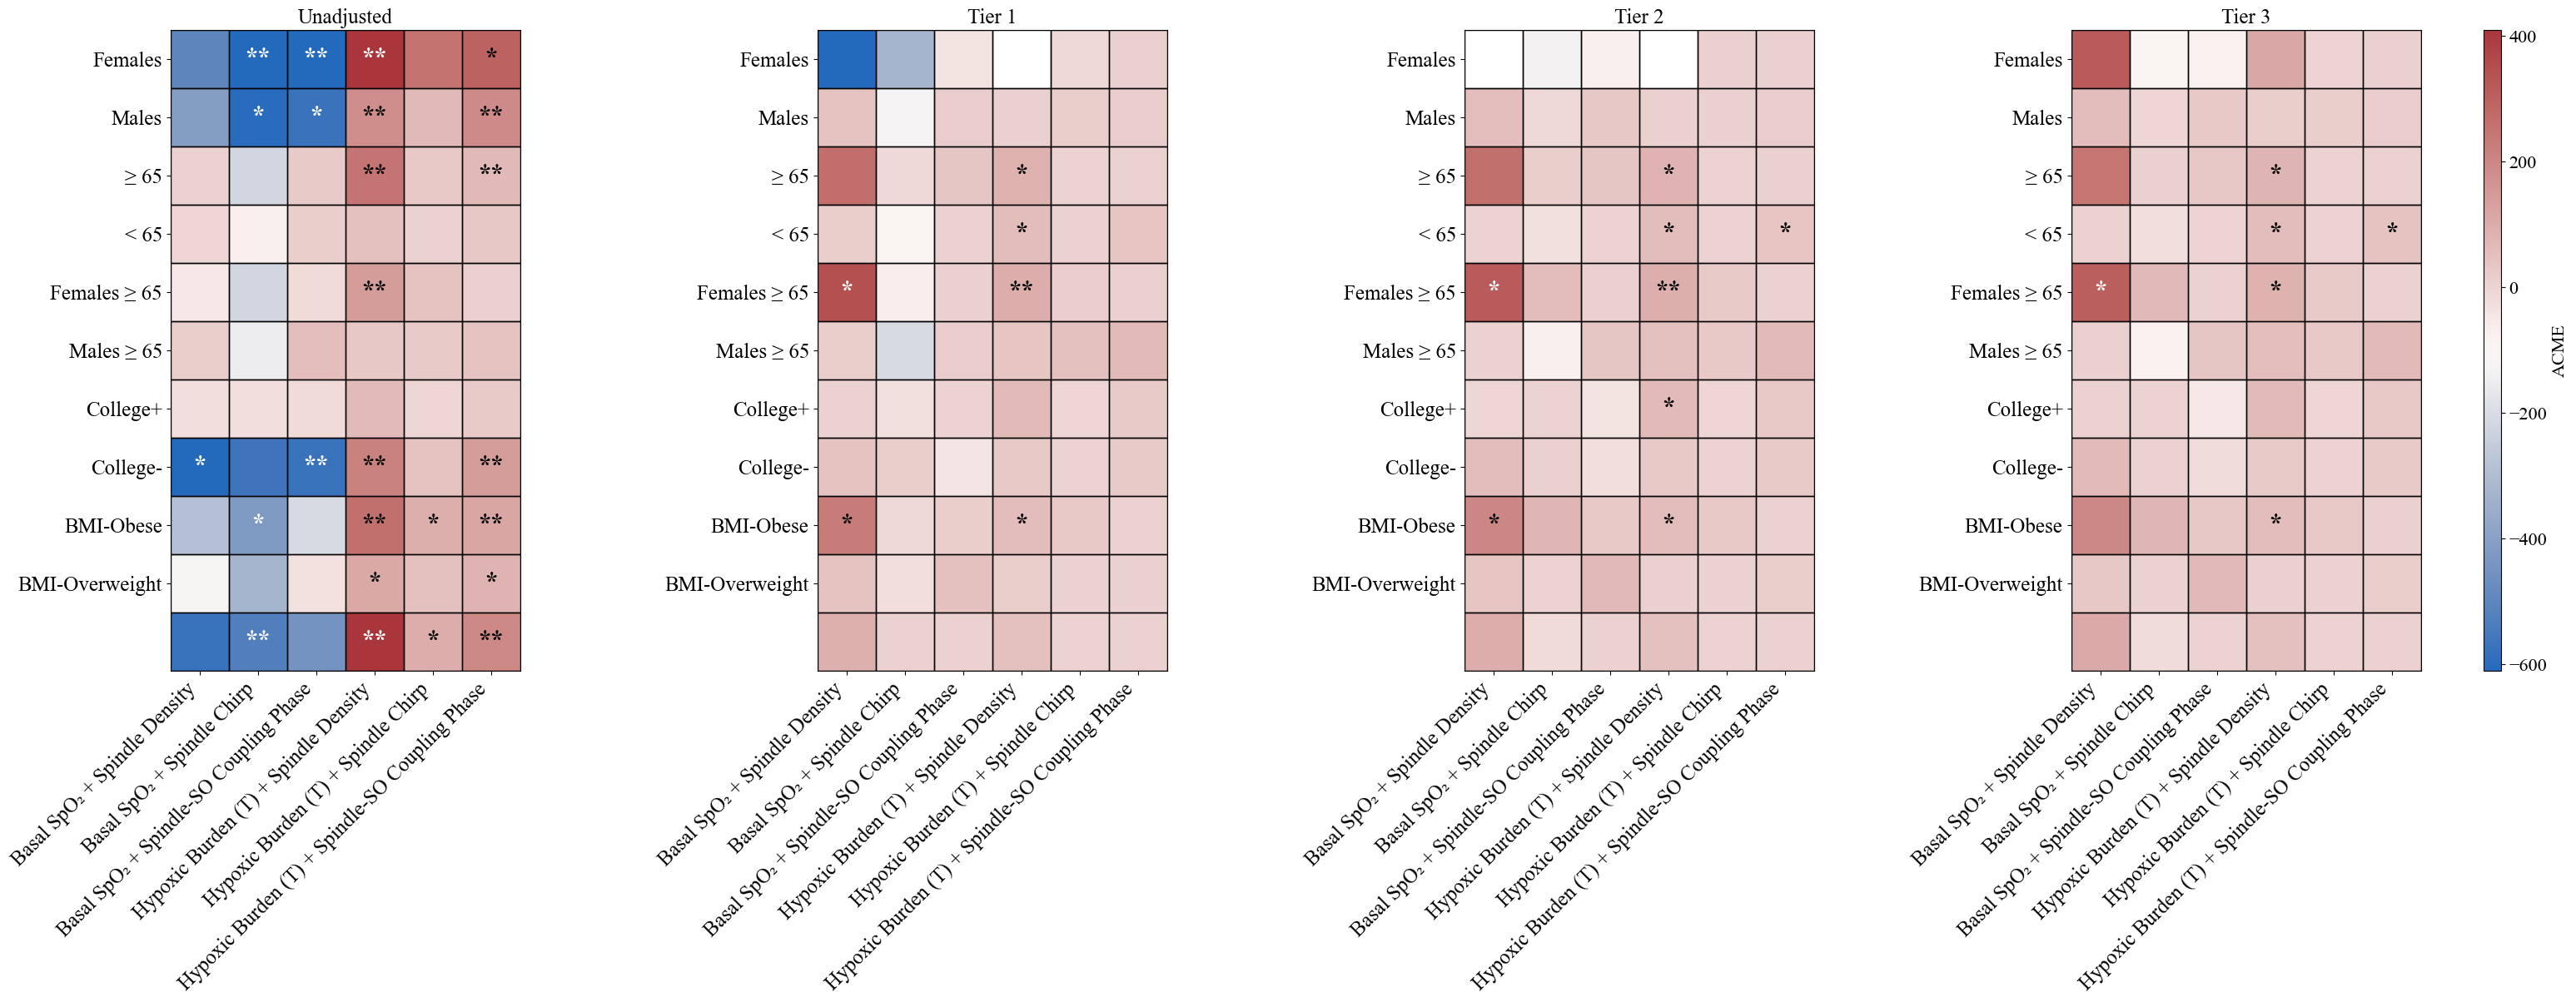

In [7]:
# Generate heat map of ACME values and significance 

# Set font family 
plt.rcParams['font.family'] = 'Times New Roman'


# Set up 4 heat maps for each covariate grouping 
heatmaps = [
    ("Unadjusted", unadjusted_all),
    ("Tier 1", group1_all),
    ("Tier 2", group2_all),
    ("Tier 3", group3_all)
]

# Set custom labels using pair and stratification 
custom_x_labels = group1_all["Pair"].cat.categories.tolist()
custom_y_labels = group1_all["Stratification"].cat.categories.tolist()

# Create 4-column plot
fig, axes = plt.subplots(1, 4, figsize=(40, 10), sharey=False, gridspec_kw={'width_ratios': [1, 1, 1, 1]})

# Set colorbar
vmin, vmax = -610,410  
cmap = sns.color_palette("vlag", as_cmap=True)
norm = plt.Normalize(vmin, vmax)

# Loop through for each of the four covariate groups 
for ax, (title, df_original) in zip(axes, heatmaps):
    df = df_original.copy()
    # Pivot to matrix form
    # Apply -1 transformation to hb for interpretation  
    df.loc[df["Exposure"] == "hb_desat", "ACME"] *= -1
    matrix = df.pivot(index="Stratification", columns="Pair", values="ACME")
    pval_matrix = df.pivot(index="Stratification", columns="Pair", values="ACME_pval_empirical")

    # Show heatmap with ACME effects 
    im = ax.imshow(matrix.values, cmap=cmap, norm=norm)
    
    # Labels
    ax.set_xticks(np.arange(len(custom_x_labels)))
    ax.set_yticks(np.arange(len(custom_y_labels)))
    ax.set_xticklabels(custom_x_labels, rotation=45, ha="right", fontsize=18)
    ax.set_yticklabels(custom_y_labels, fontsize=18)
    ax.set_title(title, fontsize=18)

    # Cell borders
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
            ax.add_patch(rect)

            # Annotate with asterisk to show p-value 
            # Use white vs black for visibility 
            p = pval_matrix.iloc[i, j]
            acme = matrix.iloc[i, j]
            if pd.notna(p):
                color = "white" if abs(acme)>300 else "black"
                if p < 0.01:
                    ax.text(j, i, "**", ha='center', va='center', fontsize=22, color=color, fontweight='bold')
                elif p < 0.05:
                    ax.text(j, i, "*", ha='center', va='center', fontsize=22, color=color, fontweight='bold')

# Colorbar on last axis
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.75)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("ACME", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Save and show plot 
fig.subplots_adjust(wspace=0.01)  
#plt.savefig("Figures/stratified_heatmap_7.8.2025.png", dpi=600, bbox_inches='tight')
plt.show()


### Performance Metric Table 

In [8]:
# Filter significant results from each group
unadjusted_sig = unadjusted_all[unadjusted_all["ACME_pval_empirical"].astype(float) < 0.05].copy()
group1_sig = group1_all[group1_all["ACME_pval_empirical"].astype(float) < 0.05].copy()
group2_sig = group2_all[group2_all["ACME_pval_empirical"].astype(float) < 0.05].copy()
group3_sig = group3_all[group3_all["ACME_pval_empirical"].astype(float) < 0.05].copy()

# Concatenate results into one df for performance metrics 
performance = pd.concat([unadjusted_sig,group1_sig, group2_sig, group3_sig], ignore_index=True)

# Drop irrelevant columns 
performance= performance.drop(columns={"Pair", "Source_File", "AUC_5y", "N_Used", "ADE_Bootstrap_Success"})
performance = performance.drop(columns=performance.loc[:, "ACME":"ADE_pval_empirical"].columns)

# Rename columns 
performance = performance.rename(columns={"Covariate_Set":"Covariates", "Std_Dev_Y":"SD (Mediator)",
                                         "C_Index":"C-Index", "AUC_10y":"AUC (10y)", "AUC_15y":"AUC (15y)"})
exposure_map = {
    "avg_spo2_no_desat_NREM": "Avg Baseline SpO₂ NREM",
    "hb_desat": "Hypoxic Burden"
}
mediator_map = {
    "SP_DENS_all_C": "Spindle Density",
    "SP_CHIRP_all_C": "Spindle Chirp",
    "SP_R_PHASE_IF_all_C": "SO Phase Coupling"
}

performance["Exposure"] = performance["Exposure"].replace(exposure_map)
performance["Mediator"] = performance["Mediator"].replace(mediator_map)

print(performance.columns)

# Order by covariate group and by exposure/mediator pairs 
covariate_order = ["Unadjusted", "Group1", "Group2", "Group3"]
exposure_order = ["Avg Baseline SpO₂ NREM", "Hypoxic Burden"]
mediator_order = ["Spindle Density", "Spindle Chirp", "SO Phase Coupling"]

# Set as ordered categories
performance["Covariates"] = pd.Categorical(performance["Covariates"], categories=covariate_order, ordered=True)
performance["Exposure"] = pd.Categorical(performance["Exposure"], categories=exposure_order, ordered=True)
performance["Mediator"] = pd.Categorical(performance["Mediator"], categories=mediator_order, ordered=True)

# Sort
performance = performance.sort_values(["Covariates", "Exposure", "Mediator"]).reset_index(drop=True)

# Reorder such that stratification column is at the beginning 
cols = performance.columns.tolist()
cols.insert(3, cols.pop(cols.index("Stratification")))
performance = performance[cols]

# Round values 
cols_to_round = ["RMSE", "SD (Mediator)", "C-Index", "AUC (10y)", "AUC (15y)", "C_Index_CI_Lower", "C_Index_CI_Upper",
              "AUC_10y_CI_Lower", "AUC_10y_CI_Upper", "AUC_15y_CI_Lower", "AUC_15y_CI_Upper" ]  # update as needed
performance[cols_to_round] = performance[cols_to_round].round(3)
for metric, lower, upper in [
    ("C-Index", "C_Index_CI_Lower", "C_Index_CI_Upper"),
    ("AUC (10y)", "AUC_10y_CI_Lower", "AUC_10y_CI_Upper"),
    ("AUC (15y)", "AUC_15y_CI_Lower", "AUC_15y_CI_Upper")
]:
    performance[f"{metric} (95% CI)"] = performance.apply(
        lambda row: f"{row[metric]}\n[{row[lower]}, {row[upper]}]", axis=1
    )

Index(['Exposure', 'Mediator', 'Covariates', 'RMSE', 'SD (Mediator)',
       'C-Index', 'C_Index_CI_Lower', 'C_Index_CI_Upper', 'AUC (10y)',
       'AUC_10y_CI_Lower', 'AUC_10y_CI_Upper', 'AUC (15y)', 'AUC_15y_CI_Lower',
       'AUC_15y_CI_Upper', 'ACME_Bootstrap_Success', 'C_Index.1',
       'Stratification'],
      dtype='object')


In [9]:
# Ensure final order/keep relevant columns 
performance_final = performance[['Exposure', 'Mediator', 'Covariates', 'Stratification', 'RMSE', 'SD (Mediator)', 
                                 'C-Index (95% CI)', 'AUC (10y) (95% CI)','AUC (15y) (95% CI)']].copy()
print(performance_final.head())
print(performance_final.shape)

                 Exposure         Mediator  Covariates  Stratification   RMSE  \
0  Avg Baseline SpO₂ NREM  Spindle Density  Unadjusted        College+  0.937   
1  Avg Baseline SpO₂ NREM    Spindle Chirp  Unadjusted         Females  0.124   
2  Avg Baseline SpO₂ NREM    Spindle Chirp  Unadjusted        College-  0.122   
3  Avg Baseline SpO₂ NREM    Spindle Chirp  Unadjusted  BMI-Overweight  0.122   
4  Avg Baseline SpO₂ NREM    Spindle Chirp  Unadjusted             NaN  0.123   

   SD (Mediator)       C-Index (95% CI)     AUC (10y) (95% CI)  \
0          0.941   0.62\n[0.572, 0.667]   0.66\n[0.534, 0.787]   
1          0.124  0.612\n[0.573, 0.652]  0.598\n[0.465, 0.731]   
2          0.122  0.594\n[0.556, 0.632]   0.611\n[0.49, 0.732]   
3          0.123   0.574\n[0.53, 0.618]  0.609\n[0.482, 0.736]   
4          0.124      0.615\n[nan, nan]      0.598\n[nan, nan]   

      AUC (15y) (95% CI)  
0  0.677\n[0.591, 0.763]  
1  0.683\n[0.612, 0.754]  
2  0.618\n[0.548, 0.688]  
3   0.57

In [10]:
# Export to Excel for manuscript 
#performance.to_excel("NAME FILE.xlsx", index=False)

### All performance results

In [11]:
# Making performance table for ALL covariate groups 
unadjusted_sig = unadjusted_all.copy()
group1_sig = group1_all.copy()
group2_sig = group2_all.copy()
group3_sig = group3_all.copy()

# Concatenate and drop irrelevant columns 
performance = pd.concat([unadjusted_sig,group1_sig, group2_sig, group3_sig], ignore_index=True)

performance= performance.drop(columns={"Pair", "Source_File", "AUC_5y", "N_Used", "ADE_Bootstrap_Success"})
performance = performance.drop(columns=performance.loc[:, "ACME":"ADE_pval_empirical"].columns)

# Rename columns 
performance = performance.rename(columns={"Covariate_Set":"Covariates", "Std_Dev_Y":"SD (Mediator)",
                                         "C_Index":"C-Index", "AUC_10y":"AUC (10y)", "AUC_15y":"AUC (15y)"})
exposure_map = {
    "avg_spo2_no_desat_NREM": "Avg Baseline SpO₂ NREM",
    "hb_desat": "Hypoxic Burden"
}
mediator_map = {
    "SP_DENS_all_C": "Spindle Density",
    "SP_CHIRP_all_C": "Spindle Chirp",
    "SP_R_PHASE_IF_all_C": "SO Phase Coupling"
}
performance["Exposure"] = performance["Exposure"].replace(exposure_map)
performance["Mediator"] = performance["Mediator"].replace(mediator_map)


# Order by covariates and exposure/mediator pairs 
covariate_order = ["Unadjusted", "Group1", "Group2", "Group3"]
exposure_order = ["Avg Baseline SpO₂ NREM", "Hypoxic Burden"]
mediator_order = ["Spindle Density", "Spindle Chirp", "SO Phase Coupling"]

# Set as ordered categories
performance["Covariates"] = pd.Categorical(performance["Covariates"], categories=covariate_order, ordered=True)
performance["Exposure"] = pd.Categorical(performance["Exposure"], categories=exposure_order, ordered=True)
performance["Mediator"] = pd.Categorical(performance["Mediator"], categories=mediator_order, ordered=True)

# Sort
performance = performance.sort_values(["Covariates", "Exposure", "Mediator"]).reset_index(drop=True)

# Move Stratification columns 
cols = performance.columns.tolist()
cols.insert(3, cols.pop(cols.index("Stratification")))
performance = performance[cols]

# Round values 
cols_to_round = ["RMSE", "SD (Mediator)", "C-Index", "AUC (10y)", "AUC (15y)"]  # update as needed
performance[cols_to_round] = performance[cols_to_round].round(3)

# Format the CI values 
for metric, lower, upper in [
    ("C-Index", "C_Index_CI_Lower", "C_Index_CI_Upper"),
    ("AUC (10y)", "AUC_10y_CI_Lower", "AUC_10y_CI_Upper"),
    ("AUC (15y)", "AUC_15y_CI_Lower", "AUC_15y_CI_Upper")
]:
    performance[f"{metric} (95% CI)"] = performance.apply(
        lambda row: f"{row[metric]} ({row[lower]}, {row[upper]})", axis=1
    )

# Drop individual CI columns 
performance.drop(columns=[
    "C_Index_CI_Lower", "C_Index_CI_Upper",
    "AUC_10y_CI_Lower", "AUC_10y_CI_Upper",
    "AUC_15y_CI_Lower", "AUC_15y_CI_Upper"
], inplace=True)


print(performance.head())

                 Exposure         Mediator  Covariates Stratification   RMSE  \
0  Avg Baseline SpO₂ NREM  Spindle Density  Unadjusted        Females  0.902   
1  Avg Baseline SpO₂ NREM  Spindle Density  Unadjusted          Males  0.934   
2  Avg Baseline SpO₂ NREM  Spindle Density  Unadjusted           ≥ 65  0.868   
3  Avg Baseline SpO₂ NREM  Spindle Density  Unadjusted           < 65  0.912   
4  Avg Baseline SpO₂ NREM  Spindle Density  Unadjusted   Females ≥ 65  0.805   

   SD (Mediator)  C-Index  AUC (10y)  AUC (15y)  ACME_Bootstrap_Success  \
0          0.904    0.631      0.703      0.706                     998   
1          0.934    0.637      0.686      0.690                    1000   
2          0.868    0.545      0.552      0.579                    1000   
3          0.912    0.582      0.799      0.679                    1000   
4          0.806    0.506      0.520      0.497                     998   

   C_Index.1                              C-Index (95% CI)  \
0     